# Prediksi Harga Mobil Bekas di Arab Saudi
## Notebook TDSP – Platform Syarah.com

Notebook ini disusun ulang berdasarkan analisis pada dokumen *Prediksi Harga Mobil Bekas di Arab Saudi pada Platform Syarah.com Menggunakan Machine Learning* dan diorganisasi mengikuti kerangka **Microsoft Team Data Science Process (TDSP)**: Business Understanding, Data Acquisition & Understanding, Modeling, Deployment, dan Customer Acceptance.

> Catatan: Ubah path dataset, parameter model, serta visualisasi sesuai kebutuhan proyek aktual.

## 1. Business Understanding

### 1.1 Latar Belakang
- Pasar mobil bekas di Arab Saudi berkembang pesat dan didukung oleh platform daring seperti **Syarah.com**.
- Penentuan harga mobil bekas sulit dilakukan secara konsisten karena banyak faktor (merek, tipe, tahun produksi, ukuran mesin, jarak tempuh, lokasi, dll).
- Tanpa panduan harga yang akurat, penjual berisiko memasang harga terlalu tinggi (mobil sulit terjual) atau terlalu rendah (merugikan penjual), sementara pembeli berisiko membayar di atas harga pasar.

### 1.2 Tujuan Analisis
- Membangun **model machine learning** yang dapat memprediksi **harga mobil bekas** di Arab Saudi berdasarkan fitur listing Syarah.com.
- Mengidentifikasi fitur penting yang memengaruhi harga.
- Memberikan insight bisnis bagi Product Manager.

### 1.3 Metrik Evaluasi
- **MAE (Mean Absolute Error)**
- **MAPE (Mean Absolute Percentage Error)**

## 2. Data Acquisition & Understanding

**Dataset:** `UsedCarsSA_unClean_EN.csv`

Kolom penting: `Make`, `Type`, `Year`, `Engine_Size`, `Mileage`, `Price`, `Region`, `Fuel_Type`, `Gear_Type`, dll.

Jumlah baris: ± 8.248 entri.

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [3]:
DATA_PATH = '../Dataset/UsedCarsSA_unClean_EN.csv'
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()

Shape: (8248, 15)


,Link,Make,Type,Year,Origin,Color,Options,Engine_Size,Fuel_Type,Gear_Type,Condition,Mileage,Region,Price,Negotiable
0,https://syarah.com/%D9%83%D8%B1%D8%A7%D9%8A%D8...,Chrysler,C300,2018,Saudi,Black,Full,5.70,Gas,Automatic,Used,103000,Riyadh,114000,False
1,https://syarah.com/%D9%86%D9%8A%D8%B3%D8%A7%D9...,Nissan,Patrol,2016,Saudi,White,Full,4.80,Gas,Automatic,Used,5448,Riyadh,Negotiable,True
2,https://syarah.com/online/%D9%86%D9%8A%D8%B3%D...,Nissan,Sunny,2019,Saudi,Silver,Standard,1.50,Gas,Automatic,Used,72418,Riyadh,27500,False
3,https://syarah.com/online/%D9%87%D9%88%D9%86%D...,Hyundai,Elantra,2019,Saudi,Grey,Standard,1.60,Gas,Automatic,Used,114154,Riyadh,43000,False
4,https://syarah.com/online/%D9%87%D9%88%D9%86%D...,Hyundai,Elantra,2019,Saudi,Silver,Semi Full,2.00,Gas,Automatic,Used,41912,Riyadh,59500,False


## 3. Data Preparation & Feature Engineering

- Hapus kolom tidak relevan (`Condition`, `Link`, `Negotiable`).
- Tangani nilai hilang pada kategori & numerik (`Engine_Size`).
- Konversi `Price` ke numerik dan buang nilai 'Negotiable'.

In [4]:
df_clean = df.copy()
if 'Condition' in df_clean.columns and df_clean['Condition'].nunique()==1:
    df_clean = df_clean.drop(columns=['Condition'])
if 'Price' in df_clean.columns:
    df_clean = df_clean[~df_clean['Price'].astype(str).str.contains('Negotiable', case=False, na=False)]
    df_clean['Price'] = pd.to_numeric(df_clean['Price'], errors='coerce')
df_clean = df_clean.dropna(subset=['Price'])
df_clean['Origin'] = df_clean['Origin'].fillna('Unknown')
df_clean['Gear_Type'] = df_clean['Gear_Type'].fillna(df_clean['Gear_Type'].mode()[0])
df_clean['Options'] = df_clean['Options'].fillna('Unknown')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5652 entries, 0 to 8247
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Link         5652 non-null   object 
 1   Make         5652 non-null   object 
 2   Type         5652 non-null   object 
 3   Year         5652 non-null   int64  
 4   Origin       5652 non-null   object 
 5   Color        5652 non-null   object 
 6   Options      5652 non-null   object 
 7   Engine_Size  4425 non-null   float64
 8   Fuel_Type    5652 non-null   object 
 9   Gear_Type    5652 non-null   object 
 10  Mileage      5652 non-null   int64  
 11  Region       5652 non-null   object 
 12  Price        5652 non-null   int64  
 13  Negotiable   5652 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(9)
memory usage: 623.7+ KB


## 4. Exploratory Data Analysis (EDA)

- **Year vs Price:** positif.
- **Engine_Size vs Price:** positif.
- **Mileage vs Price:** negatif.

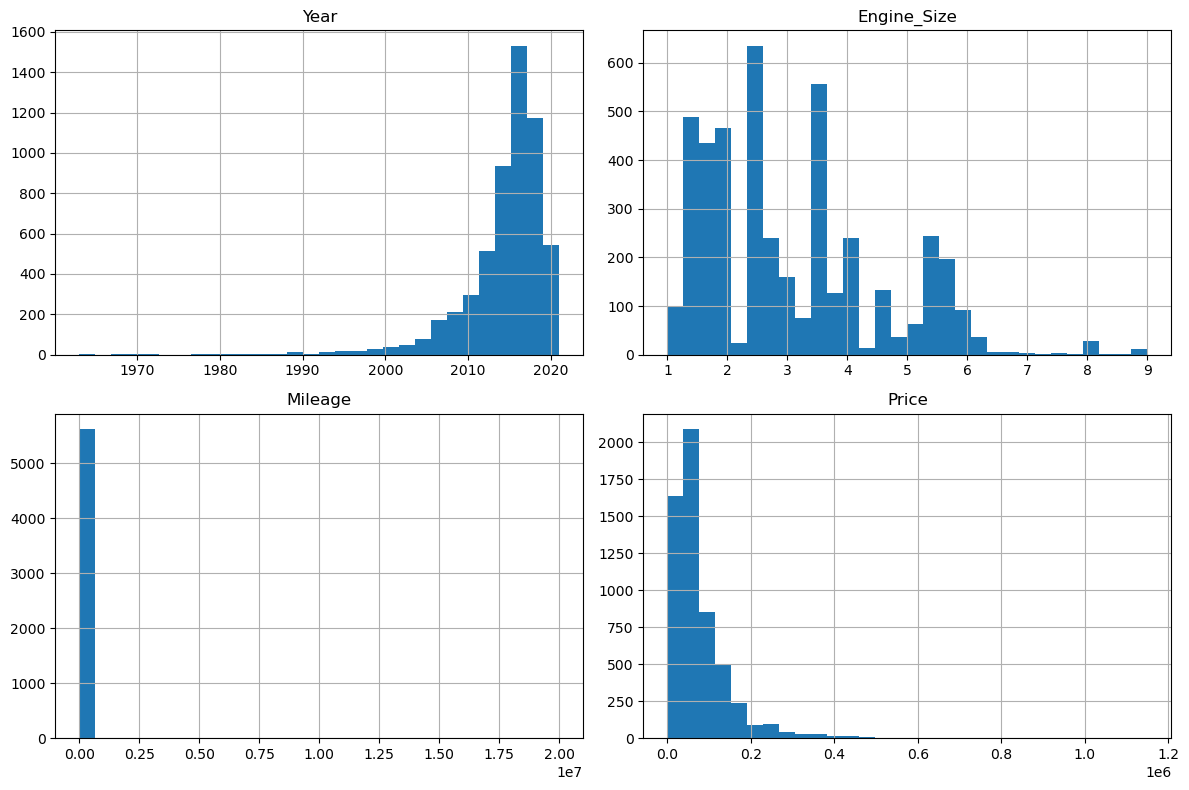

In [5]:
numeric_cols = ['Year','Engine_Size','Mileage','Price']
df_clean[numeric_cols].hist(bins=30, figsize=(12,8)); plt.tight_layout(); plt.show()

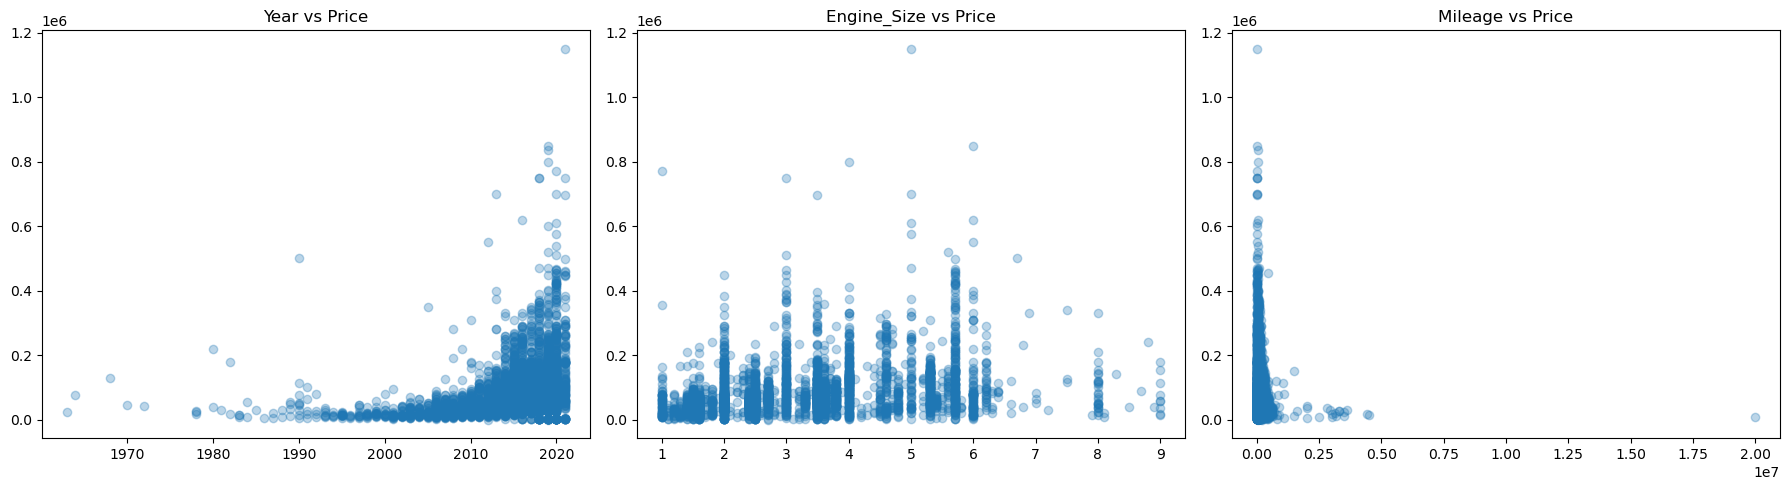

In [6]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
axes[0].scatter(df_clean['Year'], df_clean['Price'], alpha=0.3); axes[0].set_title('Year vs Price')
axes[1].scatter(df_clean['Engine_Size'], df_clean['Price'], alpha=0.3); axes[1].set_title('Engine_Size vs Price')
axes[2].scatter(df_clean['Mileage'], df_clean['Price'], alpha=0.3); axes[2].set_title('Mileage vs Price')
plt.tight_layout(); plt.show()

## 5. Modeling

Gunakan pipeline scikit-learn dan bandingkan 3 model: Linear Regression, Random Forest, Gradient Boosting.

In [7]:
# === MODELING: train & evaluasi 3 model (Linear, RF, GB) ===

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Kalau belum ada, definisikan MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Pastikan target tidak NaN
df_model = df_clean.dropna(subset=['Price']).copy()

# 1. Fitur & target
X = df_model.drop(columns=['Price'])
y = df_model['Price']

num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()

print("Numeric features :", num_features)
print("Categorical feats:", cat_features)

# 2. Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test  shape:", X_test.shape)

# 3. Preprocessing: imputer + scaler / one-hot
num_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

pre = ColumnTransformer([
    ('num', num_tf, num_features),
    ('cat', cat_tf, cat_features)
])

# 4. Helper untuk train & evaluasi
def eval_model(model, name):
    pipe = Pipeline([
        ('pre', pre),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'{name}: MAE={mae:,.2f}, MAPE={mape:,.2f}%')
    return {
        'name': name,
        'mae': mae,
        'mape': mape,
        'pipeline': pipe
    }

# 5. Jalankan 3 model
results = []
results.append(eval_model(LinearRegression(), 'LinearRegression'))
results.append(eval_model(RandomForestRegressor(n_estimators=200, random_state=42), 'RandomForest'))
results.append(eval_model(GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42), 'GradientBoosting'))

# 6. Pilih model terbaik (berdasarkan MAE)
best = min(results, key=lambda r: r['mae'])
best_name = best['name']
best_mae = best['mae']
best_mape = best['mape']
best_pipeline = best['pipeline']

print("\nBest model based on MAE:")
print(f"- Name : {best_name}")
print(f"- MAE  : {best_mae:,.2f}")
print(f"- MAPE : {best_mape:,.2f}%")

# (Opsional) simpan model
import joblib
joblib.dump(best_pipeline, f'model_syarah_best_{best_name.lower()}.joblib')


Numeric features : ['Year', 'Engine_Size', 'Mileage']
Categorical feats: ['Link', 'Make', 'Type', 'Origin', 'Color', 'Options', 'Fuel_Type', 'Gear_Type', 'Region', 'Negotiable']
Train shape: (4521, 13)
Test  shape: (1131, 13)
LinearRegression: MAE=23,704.17, MAPE=10,911.70%
RandomForest: MAE=16,858.95, MAPE=13,198.76%
GradientBoosting: MAE=20,778.92, MAPE=11,115.21%

Best model based on MAE:
- Name : RandomForest
- MAE  : 16,858.95
- MAPE : 13,198.76%


['model_syarah_best_randomforest.joblib']

In [8]:
import joblib

# Pilih model terbaik berdasarkan MAE
best = min(results, key=lambda r: r['mae'])

print("Best model:", best['name'])
print(f"MAE  : {best['mae']:,.2f}")
print(f"MAPE : {best['mape']:,.2f}%")

# Simpan model terbaik
model_filename = f"model_syarah_best_{best['name'].replace(' ', '_').lower()}.joblib"
joblib.dump(best['pipeline'], model_filename)

print(f"\nModel tersimpan sebagai: {model_filename}")

Best model: RandomForest
MAE  : 16,858.95
MAPE : 13,198.76%

Model tersimpan sebagai: model_syarah_best_randomforest.joblib


## 6. Deployment & Customer Acceptance

- **Deployment:** Simpan model (`joblib`) lalu sajikan sebagai REST API (mis. Flask/FastAPI).
- **Customer Acceptance:** Validasi hasil prediksi dengan Product Manager, lakukan UAT dan dokumentasi pipeline.

Notebook ini dapat dijadikan baseline Microsoft TDSP untuk proyek prediksi harga mobil bekas di Syarah.com.